In [52]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from loaders import clean_text_for_pattern_letter
from temp_text_puh import template_str
# input_str = clean_text_for_pattern_letter(template_str, out_len=len(template_str))
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
input_str = '<' + input_str + '>'
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
           'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', '\'', '>']
print(f'{letters=}')
# print(f'{input_str=}')

len(letters)=32
502
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', "'", '>']


In [54]:
# generate SDR

SDR_len = 128 # 128
sparsity = 4 # 4
max_overlap = 1 # 1

sparse_prob = sparsity / SDR_len

letter_SDRs = {}

for letter in letters:
    while True:
        rnd_SDR = np.random.choice([0, 1], SDR_len, True, [1 - sparse_prob, sparse_prob])

        if (rnd_SDR > 0).sum() != sparsity:
            continue
        
        is_over_max = False
        for SDR in letter_SDRs.values():
            if (SDR & rnd_SDR).sum() > max_overlap:
                is_over_max = True
                break
        
        if is_over_max:
            continue
            
        break
    
    # print(f'{letter}')
    letter_SDRs.setdefault(letter, rnd_SDR)

for letter, SDR in letter_SDRs.items():
    print(f'{letter} : {(SDR > 0).sum()} {SDR.tolist()}')

a : 4 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
b : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
c : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

In [55]:
# text to SDRs
input_SDRs = []

for inp in input_str:
    input_SDRs.append(letter_SDRs[inp])

print(f'{len(input_SDRs)=}')

# for SDR in input_SDRs:
#     print(f'{SDR.tolist()}')

len(input_SDRs)=502


In [56]:
# init start column
column_size = 16

start_SDR = letter_SDRs['<']

start_I = np.zeros((start_SDR.size, column_size))

active_start_SDR_idx = np.where(start_SDR == 1)

for as_idx in active_start_SDR_idx[0]:
    rnd_active = np.random.randint(column_size)

    start_I[as_idx][rnd_active] = 1

# for col in np.rot90(start_I):
#     print(f'{col.astype(int).tolist()}')

In [57]:
I = np.zeros((SDR_len, column_size))
O = np.zeros((SDR_len, column_size))

W = np.random.rand(SDR_len, column_size, SDR_len * column_size) * 1e-2

V = np.zeros((SDR_len, column_size))

prec = 1e-30

# train

epoch_cnt = 1

eps0 = 0.003

eps0_V = 0.09

for epoch_idx in range(epoch_cnt):
    I = np.copy(start_I)

    for SDR in input_SDRs[1:]:
        rsh_I = I.reshape(SDR_len * column_size)

        O = np.dot(W, rsh_I)

        O /= np.max(np.abs(O)) + prec

        nV = np.abs(V - np.max(V, axis=1)[np.newaxis].T)
        nV /= np.max(nV, axis=1)[np.newaxis].T + prec

        OV = O + nV * eps0_V

        OV *= SDR[np.newaxis].T
        max_O = np.max(OV, axis=1)

        O *= SDR[np.newaxis].T
        O[OV < max_O[np.newaxis].T] = 0
        max_O_idx = np.where(O != 0)

        W[max_O_idx] += (rsh_I - W[max_O_idx] * O[max_O_idx][..., np.newaxis]) * eps0

        # winners
        V[max_O_idx] += 1

        # recur
        O[O != 0] = 1

        I = np.copy(O)

# O.shape
print(np.mean(V, axis=1).tolist())
print(np.sum(V == 0))
print(np.sum((V > 0), axis=1).tolist())
# for col in np.rot90(V):
#     print(f'{col.astype(int).tolist()}')

[0.0, 0.0, 2.75, 0.0, 1.8125, 0.0, 0.0, 0.0625, 1.6875, 2.1875, 0.0, 0.8125, 0.0, 1.375, 2.0, 0.0, 0.4375, 0.0, 1.5, 5.1875, 0.25, 0.0, 0.0, 0.4375, 0.0, 0.0, 0.5625, 0.0, 0.0, 1.5, 2.1875, 0.5, 0.0, 0.0625, 0.0, 0.8125, 0.0, 1.375, 0.25, 0.0, 0.0625, 0.0, 0.0, 0.5, 1.8125, 1.625, 0.6875, 2.9375, 0.5625, 2.1875, 0.0, 3.125, 0.0, 0.0, 0.0, 2.0625, 0.0, 0.8125, 0.0, 2.1875, 0.0, 0.0625, 0.5625, 1.0625, 3.125, 0.0, 0.0, 2.6875, 0.0, 0.0, 1.5, 0.5, 0.5625, 0.0, 0.6875, 0.0, 0.0, 0.8125, 1.3125, 0.1875, 2.0625, 0.5625, 0.0625, 0.0, 1.5, 6.875, 2.25, 0.0, 0.0, 2.0, 6.125, 0.0, 3.125, 3.0, 0.0, 7.625, 0.0, 2.8125, 0.75, 1.875, 0.0, 0.1875, 0.0625, 0.8125, 0.0, 1.8125, 3.0625, 0.0, 0.0, 0.5625, 0.8125, 0.0, 1.8125, 1.0625, 3.5625, 0.0, 0.25, 1.6875, 0.0, 0.5, 0.0, 0.0, 0.5625, 0.0, 7.8125, 0.6875, 0.0, 0.0]
1253
[0, 0, 15, 0, 14, 0, 0, 1, 13, 16, 0, 10, 0, 11, 15, 0, 7, 0, 13, 16, 4, 0, 0, 7, 0, 0, 8, 0, 0, 14, 14, 6, 0, 1, 0, 11, 0, 13, 4, 0, 1, 0, 0, 6, 14, 14, 8, 15, 8, 14, 0, 16, 0, 0, 0, 

In [58]:
# test
error = []
over_mean_list = []
entropy_list = []
predictability_list = []

I = np.copy(start_I)

for SDR in input_SDRs[1:]:
    rsh_I = I.reshape(SDR_len * column_size)

    O = np.dot(W, rsh_I)

    max_O = np.max(O, axis=1)
    argmax_O_idx = np.argsort(max_O)[::-1][:sparsity]

    SDR_O = np.zeros(O.shape[0])
    SDR_O[argmax_O_idx] = 1

    err = (SDR.astype(int) ^ SDR_O.astype(int)).sum()
    # print(f'{err=}')
    error.append(err)

    # dividers
    over_mean = (max_O > np.mean(max_O)).sum()
    over_mean_list.append(over_mean)

    entropy = np.copy(max_O)
    entropy /= np.linalg.norm(entropy) + prec
    entropy = -1 * np.sum(entropy * np.log2(entropy))
    entropy_list.append(entropy)

    predictability = np.sum(np.abs(max_O - max_O[np.newaxis].T))
    predictability_list.append(predictability)

    O *= SDR[np.newaxis].T
    max_O = np.max(O, axis=1)
    O[O < max_O[np.newaxis].T] = 0

    # recur
    O[O != 0] = 1

    I = np.copy(O)

error = np.array(error)
mean_percent = int(np.mean(error) / (2 * sparsity) * 100)
print(f'{np.mean(error)=} {error.max()=} {error.min()=} {mean_percent=}')

# O.shape
# for col in np.rot90(O):
#     print(f'{col.astype(int).tolist()}')

np.mean(error)=0.8702594810379242 error.max()=8 error.min()=0 mean_percent=10


np.mean(over_mean_arr)=55.83233532934132 over_mean_arr.max()=67.0 over_mean_arr.min()=42.0
np.mean(entropy_arr)=39.279885130150284 entropy_arr.max()=39.41542015778217 entropy_arr.min()=38.82681108709238 entropy_arr.size=501


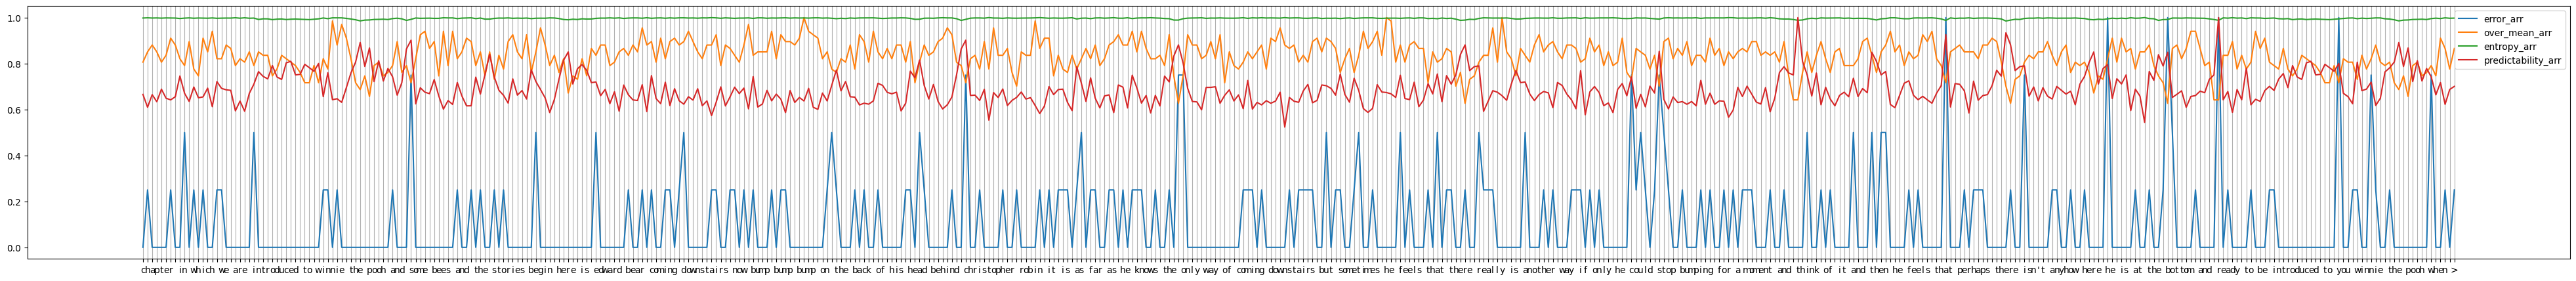

In [66]:
error_arr = np.array(error, dtype='float')
over_mean_arr = np.array(over_mean_list, dtype='float')
entropy_arr = np.array(entropy_list, dtype='float')
predictability_arr = np.array(predictability_list, dtype='float')

print(f'{np.mean(over_mean_arr)=} {over_mean_arr.max()=} {over_mean_arr.min()=}')
print(f'{np.mean(entropy_arr)=} {entropy_arr.max()=} {entropy_arr.min()=} {entropy_arr.size=}')

error_arr /= np.max(np.abs(error_arr)) + prec
# over_mean_arr = 1 / over_mean_arr
over_mean_arr /= np.max(np.abs(over_mean_arr)) + prec
entropy_arr /= np.max(np.abs(entropy_arr)) + prec
predictability_arr /= np.max(np.abs(predictability_arr)) + prec

plt.figure(figsize=(50, 5))

plt.plot(np.arange(error_arr.size), error_arr, label = "error_arr")
plt.plot(np.arange(len(over_mean_arr)), over_mean_arr, label = "over_mean_arr")
plt.plot(np.arange(len(entropy_arr)), entropy_arr, label = "entropy_arr")
plt.plot(np.arange(len(predictability_arr)), predictability_arr, label = "predictability_arr")

plt.xticks(np.arange(len(input_str[1:])), input_str[1:])
plt.grid(visible=True, axis='x')

plt.legend()
plt.show()